## Data Loading and Preprocessing

In [3]:
# Extend system path to include 'Scripts' and 'Utilities' directories for module imports
import sys
sys.path.extend(['../Scripts', '../Utilities'])

In [4]:
# Importing general utility functions from the 'import_libraries' module
from import_libraries import get_general_utils

# Getting the Path and os modules from the general utilities
Path, os = get_general_utils()

# Setting the path to the dataset. 
dataset_path = Path("../cell_images")



In [9]:
# Import Image Processing utilities
from image_processing import load_and_preprocess_images

# Define constants
SIZE = 64
COLOR_MODE = 'rgb'  

# Initialize lists for dataset and labels
infected_data, infected_labels = load_and_preprocess_images(dataset_path/'Parasitized', SIZE, COLOR_MODE)
uninfected_data, uninfected_labels   = load_and_preprocess_images(dataset_path/'Uninfected' , SIZE, COLOR_MODE)

# Combine the datasets and labels
dataset = infected_data   + uninfected_data
labels  = infected_labels + uninfected_labels

# Display basic statistics
print(f"Total images: {len(dataset)}")
print(f"Number of 'Infected' images: {len(infected_data)}")
print(f"Number of 'Uninfected' images:  {len(uninfected_data)}")

Total images: 27558
Number of 'Infected' images: 13779
Number of 'Uninfected' images:  13779


## Exploratory Data Analysis

In [10]:
# Import EDA utilities
from eda_utils import display_image_samples, plot_class_distribution

float32


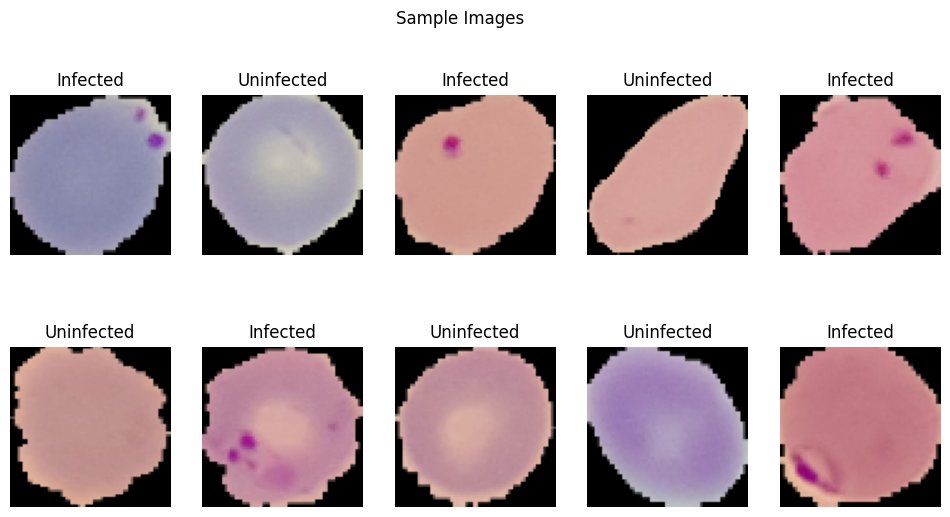

In [11]:
from import_libraries import get_data_handling_and_viz_libs
np, plt, sns, cv2 = get_data_handling_and_viz_libs()

# Plot some random samples from the dataset with their labels
samples_to_display = 10

random_indices = np.random.choice(len(dataset), samples_to_display, replace=False)
samples = [dataset[i] for i in random_indices]
sample_labels = [labels[i] for i in random_indices]
print(samples[0].dtype)
# Example usage
display_image_samples(samples, sample_labels, sample_size = samples_to_display)

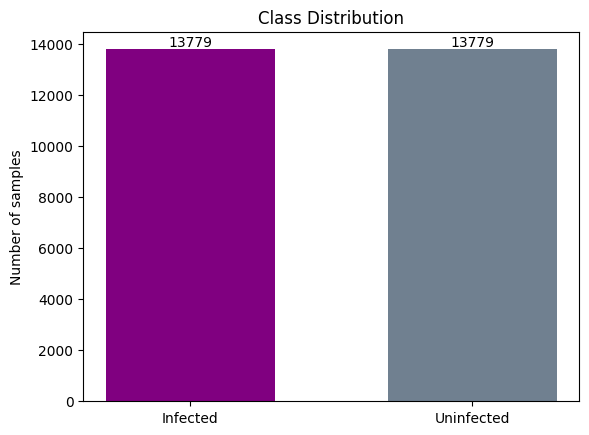

In [12]:
# Plot class distribution
plot_class_distribution(labels)

---
---

### Model Architecture

In [13]:
# Import necessary layers and functions
from import_libraries import get_core_keras_layers, get_training_components

# Get core keras layers
Input, Conv2D, Dense, Flatten, BatchNormalization, Dropout, Model = get_core_keras_layers()
# Get training components
l2, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard = get_training_components()

/Users/rajesh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [14]:
# Define convolution block
def conv_block(input_tensor, num_filters):
    """
    Adds a convolutional block to the model.

    Parameters:
    - input_tensor: Input tensor to the convolutional block
    - num_filters: Number of filters for the convolutional layers

    Returns:
    - Tensor after applying convolutional layers, BatchNormalization, and Dropout
    """
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_tensor)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    return x

# Define dense block
def dense_block(input_tensor, num_neurons):
    """
    Adds a dense block to the model.

    Parameters:
    - input_tensor: Input tensor to the dense block
    - num_neurons: Number of neurons in the dense layer

    Returns:
    - Tensor after applying Dense layer, BatchNormalization, and Dropout
    """
    x = Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001))(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    return x

# Define the input shape
INPUT_SHAPE = (SIZE, SIZE, 3)

# Input layer
inp = Input(shape=INPUT_SHAPE)

# Creating convolutional blocks
x = conv_block(inp, 32)
x = conv_block(x, 32)
x = conv_block(x, 64)
x = conv_block(x, 64)

# Flattening and dense layers
x = Flatten()(x)
x = dense_block(x, 512)
x = dense_block(x, 256)

# Output layer for binary classification
out = Dense(2, activation='softmax')(x)

# Final Model Construction
model = Model(inputs=inp, outputs=out)


### Model Compilation

In [16]:
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf

# Configure the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with explicit configurations
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  
              metrics=[
                  'accuracy',  # Overall classification accuracy
                  tf.keras.metrics.Precision(name='precision'), 
                  tf.keras.metrics.Recall(name='recall') 
              ])

# Print model summary
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 818,402 (3.12 MB)

 Trainable params: 816,482 (3.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

None


---
---

## Training the Model

In [17]:
from import_libraries import get_data_preprocessing_tools, get_sklearn_components, get_keras_utilities

### Data Partitioning

In [18]:
# Get Scikit-learn components
train_test_split, _, _, _, _ = get_sklearn_components()

# Get Keras utilities
to_categorical = get_keras_utilities()

# Splitting the Dataset into Training + Validation and Test sets
X = np.array(dataset)
Y = to_categorical(np.array(labels))

# Splitting the data into a combined (training + validation) set, and a separate test set.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Splitting the (Training + Validation) set into individual Training and Validation sets
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (16534, 64, 64, 3)
y_train shape: (16534, 2)
X_test shape: (5512, 64, 64, 3)
y_test shape: (5512, 2)
X_val shape: (5512, 64, 64, 3)
y_val shape: (5512, 2)


### Implementing Data Augmentation

In [19]:
# Get data preprocessing tools
ImageDataGenerator = get_data_preprocessing_tools()

# Define the ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range    = 15,
    width_shift_range = False,
    height_shift_range= False,
    zoom_range        = False,
    horizontal_flip   = True,
    vertical_flip     = True
)

# to create the augmented data generator
augmented_data = data_generator.flow(X_train, y_train, batch_size = 64)

### Configuring Training Callbacks

In [20]:
l2, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard = get_training_components()

#### Model Checkpoint
*   Callback to save the model with the best validation loss
*   This ensures that we always save the model in its best-performing state on the validation data

In [31]:
# model_checkpoint = ModelCheckpoint(
#     filepath = '/Models/best_CNN_for_Malaria_classifier.keras',
#     monitor  = 'accuracy',  
#     save_best_only = True,
#     verbose  = 1,
#     mode     = 'max'    
# )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='../Models/malaria_cnn_checkpoint.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

#### Early Stopping
*   Callback to stop training when the validation loss stops improving
*   This helps in preventing overfitting and reduces unnecessary training time

In [32]:
early_stopping = EarlyStopping(
    monitor  = 'val_loss',
    patience = 5,
    verbose  = 1,
    mode     = 'min'    
)

#### Adjusting the learning rate
*   Callback to reduce the learning rate when a metric has stopped improving
*   This helps in achieving smoother convergence through training

In [33]:
reduce_lr = ReduceLROnPlateau(
    monitor  = 'val_loss', 
    factor   = 0.1,   # Multiplicative factor of learning rate reduction
    patience = 4,
    min_lr   = 0.0001, # Lower bound on the learning rate
    verbose  = 1
)

In [34]:
# List of callbacks to be used in model training
callbacks_list = [model_checkpoint, early_stopping, reduce_lr]

### Executing Model Training

In [ ]:

results = model.fit(
    augmented_data,
    epochs=15,
    steps_per_epoch=len(X_train) // 64,  # Batch size = 64
    validation_data=(X_val, y_val),
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9416 - loss: 0.5392 - precision: 0.9416 - recall: 0.9416

258/258 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.9416 - loss: 0.5391 - precision: 0.9416 - recall: 0.9416 - val_accuracy: 0.9517 - val_loss: 0.4391 - val_precision: 0.9517 - val_recall: 0.9517 - learning_rate: 0.0010
Epoch 2/15
  1/258 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.9375 - loss: 0.3815 - precision: 0.9375 - recall: 0.9375

/Users/rajesh/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9375 - loss: 0.3815 - precision: 0.9375 - recall: 0.9375 - val_accuracy: 0.9514 - val_loss: 0.4408 - val_precision: 0.9514 - val_recall: 0.9514 - learning_rate: 0.0010
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9432 - loss: 0.4149 - precision: 0.9432 - recall: 0.9432

258/258 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step - accuracy: 0.9432 - loss: 0.4148 - precision: 0.9432 - recall: 0.9432 - val_accuracy: 0.9585 - val_loss: 0.3257 - val_precision: 0.9585 - val_recall: 0.9585 - learning_rate: 0.0010
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9219 - loss: 0.5051 - precision: 0.9219 - recall: 0.9219 - val_accuracy: 0.9583 - val_loss: 0.3258 - val_precision: 0.9583 - val_recall: 0.9583 - learning_rate: 0.0010
Epoch 5/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9420 - loss: 0.3419 - precision: 0.9420 - recall: 0.9420

258/258 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.9420 - loss: 0.3419 - precision: 0.9420 - recall: 0.9420 - val_accuracy: 0.9554 - val_loss: 0.2811 - val_precision: 0.9554 - val_recall: 0.9554 - learning_rate: 0.0010
Epoch 6/15
  1/258 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.9688 - loss: 0.2618 - precision: 0.9688 - recall: 0.9688

258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9688 - loss: 0.2618 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.9554 - val_loss: 0.2804 - val_precision: 0.9554 - val_recall: 0.9554 - learning_rate: 0.0010
Epoch 7/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.9490 - loss: 0.2850 - precision: 0.9490 - recall: 0.9490 - val_accuracy: 0.9211 - val_loss: 0.3799 - val_precision: 0.9211 - val_recall: 0.9211 - learning_rate: 0.0010
Epoch 8/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9688 - loss: 0.2384 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.9198 - val_loss: 0.3875 - val_precision: 0.9198 - val_recall: 0.9198 - learning_rate: 0.0010
Epoch 9/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9471 - loss: 0.2602 - precision: 0.9471 - recall: 0.9471

258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - accuracy: 0.9471 - loss: 0.2602 - precision: 0.9471 - recall: 0.9471 - val_accuracy: 0.9468 - val_loss: 0.2712 - val_precision: 0.9468 - val_recall: 0.9468 - learning_rate: 0.0010
Epoch 10/15
  1/258 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.9219 - loss: 0.3033 - precision: 0.9219 - recall: 0.9219

258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9219 - loss: 0.3033 - precision: 0.9219 - recall: 0.9219 - val_accuracy: 0.9510 - val_loss: 0.2556 - val_precision: 0.9510 - val_recall: 0.9510 - learning_rate: 0.0010
Epoch 11/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - accuracy: 0.9491 - loss: 0.2426 - precision: 0.9491 - recall: 0.9491 - val_accuracy: 0.6281 - val_loss: 1.2640 - val_precision: 0.6281 - val_recall: 0.6281 - learning_rate: 0.0010
Epoch 12/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9531 - loss: 0.2516 - precision: 0.9531 - recall: 0.9531 - val_accuracy: 0.5501 - val_loss: 1.6770 - val_precision: 0.5501 - val_recall: 0.5501 - learning_rate: 0.0010
Epoch 13/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9478 - loss: 0.2297 - precision: 0.9478 - recall: 0.9478

258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 129ms/step - accuracy: 0.9479 - loss: 0.2297 - precision: 0.9479 - recall: 0.9479 - val_accuracy: 0.9588 - val_loss: 0.2123 - val_precision: 0.9588 - val_recall: 0.9588 - learning_rate: 0.0010
Epoch 14/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9688 - loss: 0.1952 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.9581 - val_loss: 0.2125 - val_precision: 0.9581 - val_recall: 0.9581 - learning_rate: 0.0010
Epoch 15/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9507 - loss: 0.2250 - precision: 0.9507 - recall: 0.9507

258/258 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - accuracy: 0.9507 - loss: 0.2250 - precision: 0.9507 - recall: 0.9507 - val_accuracy: 0.9554 - val_loss: 0.2103 - val_precision: 0.9554 - val_recall: 0.9554 - learning_rate: 0.0010


## Model Evaluation

In [37]:
# Get Scikit-learn components
_ , classification_report, confusion_matrix, roc_curve, auc = get_sklearn_components()

### Evaluation Metrics

In [38]:
# Evaluate the model
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(f"Test Loss: {scores[0]:.5f}")

# Predict classes with the model
predictions = model.predict(np.array(X_test))
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to single-column format
y_test_single_column = np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
print(classification_report(y_test_single_column, predicted_classes))

Accuracy: 95.48%
Test Loss: 0.21863
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2797
           1       0.93      0.98      0.96      2715

    accuracy                           0.95      5512
   macro avg       0.96      0.96      0.95      5512
weighted avg       0.96      0.95      0.95      5512



In [39]:
# Calculate the average training loss over all epochs
average_train_loss = np.mean(results.history['loss'])

# Get the training loss from the last epoch
final_train_loss = results.history['loss'][-1]

print(f"Average Training Loss: {average_train_loss:.5f}")
print(f"Final Training Loss: {final_train_loss:.5f}")

Average Training Loss: 0.30603
Final Training Loss: 0.22041


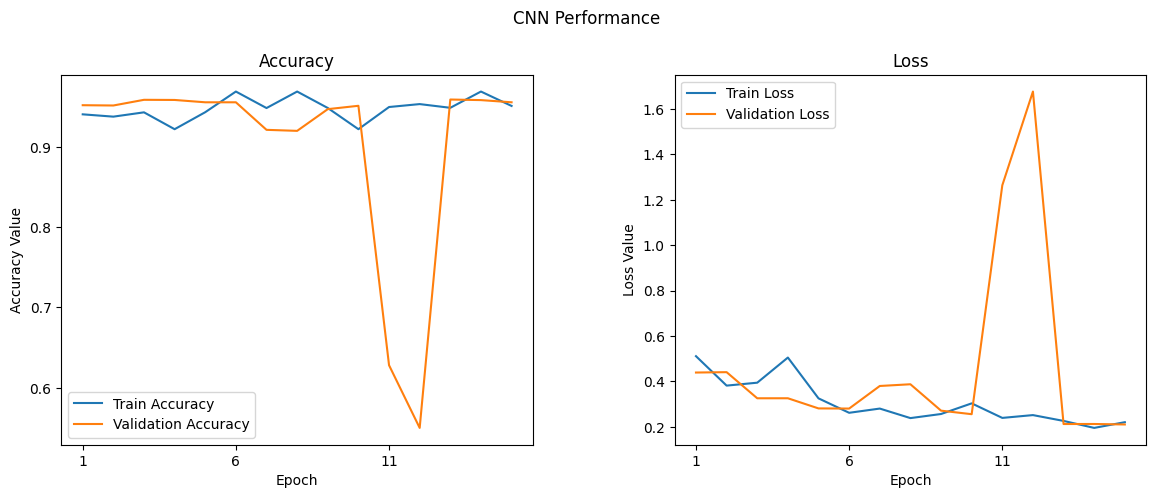

In [40]:
def plot_training_history(results):
    """
    Plot the training and validation accuracy and loss over epochs.

    This function visualizes the model's training progress. It plots two graphs:
    - The first graph shows the training and validation accuracy over epochs.
    - The second graph shows the training and validation loss over epochs.

    Parameters:
    - history: A Keras History object containing the model's training history.

    The function creates a subplot with two axes objects and plots the accuracy and
    loss values stored in the history object.
    """

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('CNN Performance', fontsize=12)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    # Extract the number of epochs and create a list of epoch numbers
    max_epoch = len(results.history['accuracy'])
    epoch_list = list(range(1, max_epoch + 1))

    # Plot training and validation accuracy
    ax1.plot(epoch_list, results.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, results.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend(loc="best")

    # Plot training and validation loss
    ax2.plot(epoch_list, results.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, results.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend(loc="best")

    # Display the plots
    plt.show()

# Call the function to plot
plot_training_history(results)

### Confusion Matrix

In [41]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_single_column, predicted_classes)
print(conf_matrix)

[[2589  208]
 [  41 2674]]


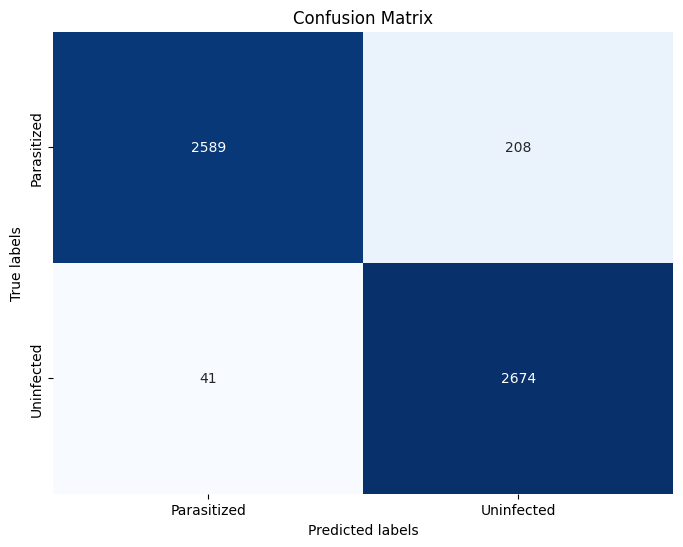

In [42]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.show()

### ROC Curve and AUC

In [43]:
# Get the predicted probabilities for the positive class (1)
y_pred_probs = model.predict(X_test)[:, 1]  

# Calculate the Receiver Operating Characteristic (ROC) curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_single_column, y_pred_probs)

# Calculate the Area Under the ROC Curve (AUC) score
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'AUC Score: {roc_auc:.2f}')

173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
AUC Score: 0.99


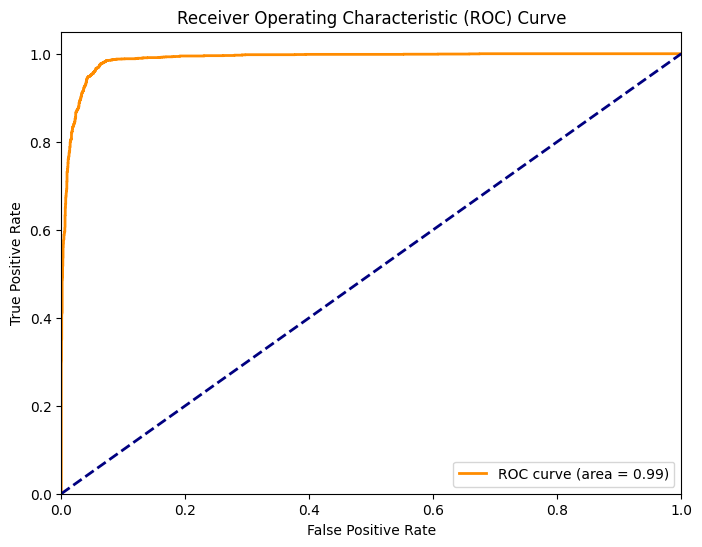

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Visual Inspection of Model Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


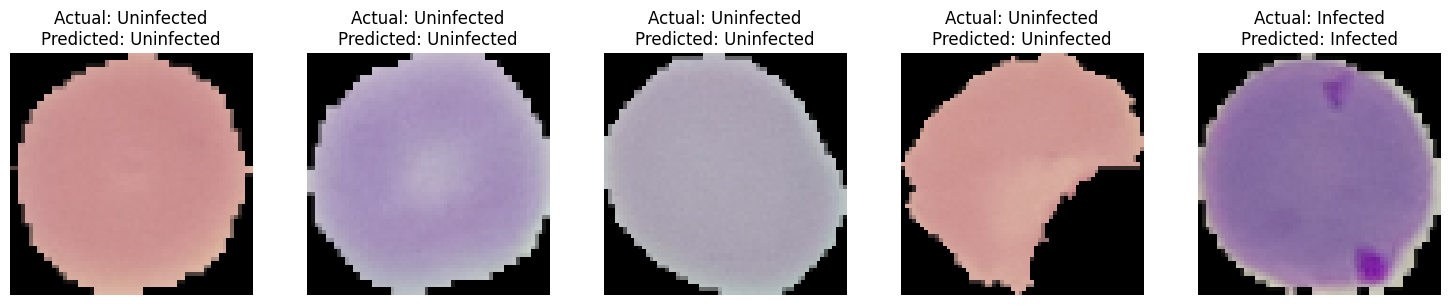

In [45]:
# Define a mapping from class indices to human-readable class names
class_mapping = {0: "Infected", 1: "Uninfected"}

# Number of random samples to display and save
num_samples = 5

# Directory to save the images
save_directory = '/Images/'  

# Create a figure with subplots for displaying
plt.figure(figsize=(15, 3))  

for i in range(num_samples):
    # Randomly pick an index from the test set
    sample_index = np.random.choice(len(X_test))
    # Retrieve the corresponding image and label from the test set
    sample_image = X_test[sample_index]

    # Generate model predictions for the sample image
    predictions = model.predict(np.expand_dims(sample_image, axis=0))
    predicted_class_idx = np.argmax(predictions, axis=1)[0]

    # Save the image without title or axis
    fig = plt.figure(figsize=(64/plt.rcParams['figure.dpi'], 64/plt.rcParams['figure.dpi']), dpi=plt.rcParams['figure.dpi'])
    plt.imshow(sample_image)
    plt.axis("off")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove padding

    # Convert the image to BGR format
    sample_image_bgr = cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR)
    sample_image_uint8 = (sample_image_bgr * 255).astype(np.uint8)

    # Save the image using OpenCV, which saves in BGR format by default
    cv2.imwrite(f"{save_directory}predicted_sample{i+1}.png", sample_image_uint8)
    plt.close(fig)

    # Add a subplot for each sample for display
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_image)
    plt.axis("off")  # Hide the axis

    # Add title with the actual and predicted classes (only for display)
    actual_class = np.argmax(y_test[sample_index])
    ax.set_title(f"Actual: {class_mapping[actual_class]}\nPredicted: {class_mapping[predicted_class_idx]}")

plt.tight_layout()  
plt.show()
